# 1. Построение модели SARIMAX

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline

Рассмотрим алгоритм построения прогноза на данных о ежемесячных объемах продаж австралийского вина с января 1980 по июль 1995 года.

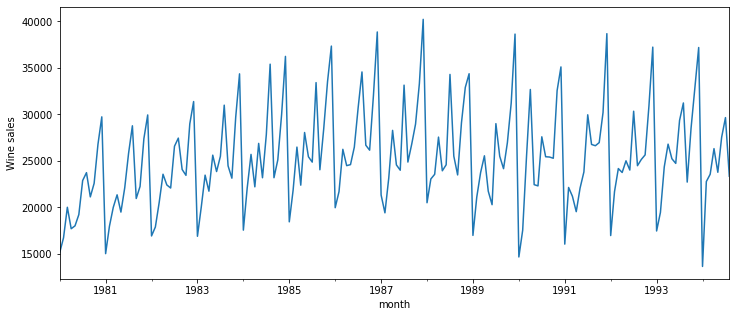

In [3]:
wine = pd.read_csv('data/monthly-australian-wine-sales.csv', 
                   index_col=['month'], parse_dates=['month'], dayfirst=True)
wine['sales'].plot(figsize=(12,5))
plt.ylabel('Wine sales')
plt.show()

## 1.1. Стабилизация дисперсии

Для стабилизации дисперсии выполним преобразование Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 0.236675
Критерий Дики-Фуллера: p=0.029565


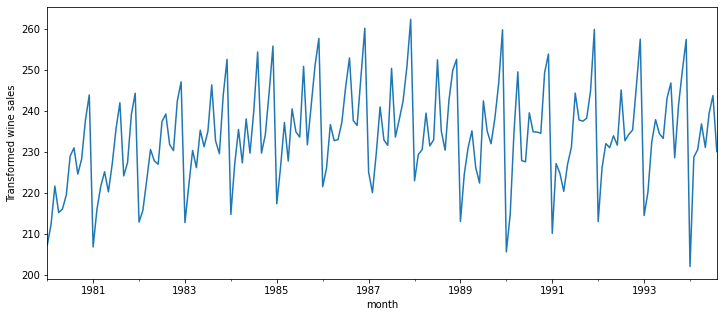

In [4]:
wine['sales'] = wine['sales'] * 1000
wine['sales_box'], lmbda = boxcox(wine['sales'])
wine['sales_box'].plot(figsize=(12,5))
plt.ylabel('Transformed wine sales')
print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)
print('Критерий Дики-Фуллера: p=%f' % adfuller(wine['sales_box'])[1])

Очевидно наличие сезонности. Сезонность будет учтена во время построения модели SARIMAX, однако для определения порядков авторегресии и скользящего среднего для начала необходимо провести дифференцирование.

## 1.2. Дифференцирование ряда

Критерий Дики-Фуллера: p=0.128317


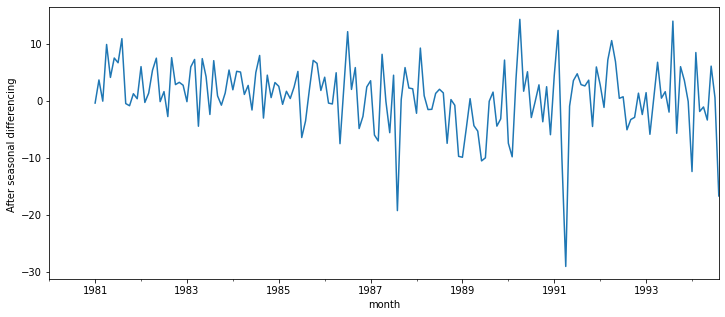

In [5]:
wine['sales_box_sdiff'] = wine['sales_box'].diff(12)
wine['sales_box_sdiff'].plot(figsize=(12,5))
plt.ylabel('After seasonal differencing ')
print('Критерий Дики-Фуллера: p=%f' % adfuller(wine['sales_box_sdiff'].dropna())[1])

Можно заметить, что по критерию Дики-Фуллера ряд не является стационарным. Проведем обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000002


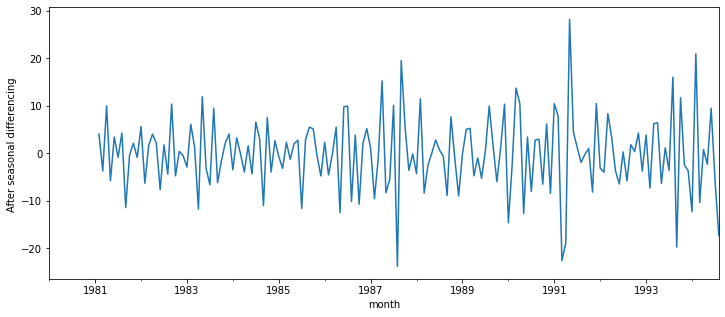

In [6]:
wine['sales_box_diff'] =  wine['sales_box_sdiff'].diff(1)
wine['sales_box_diff'].plot(figsize=(12,5))
plt.ylabel('After seasonal differencing ')
print('Критерий Дики-Фуллера: p=%f' % adfuller(wine['sales_box_diff'].dropna())[1])

Гипотеза нестационарности отвергается. Перейдем к выбору начального приближения гиперпараметров.

## 1.3. Выбор гиперпараметров модели

Для выбора порядка скользящего среднего обратимся к коррелограмме.

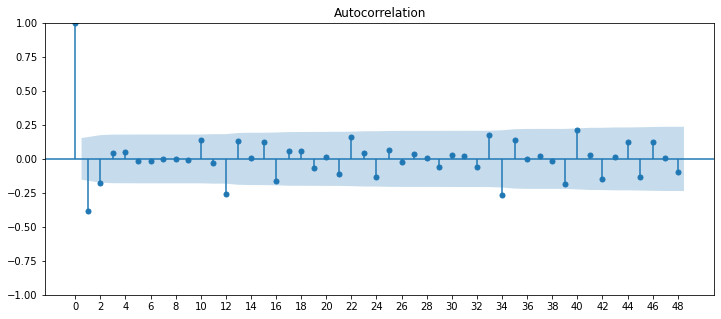

In [40]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(wine['sales_box_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Посдедний значимый лаг равен 2. А последний значимый сезонный лаг равен 1 (при лаге 12 автокорреляция значима, при 24 &ndash; незначима). Таким образом, $q_0=2, Q_0=1$.

Для выбора порядка авторегрессии обратимся к частичной автокорреляции.

/home/egor/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


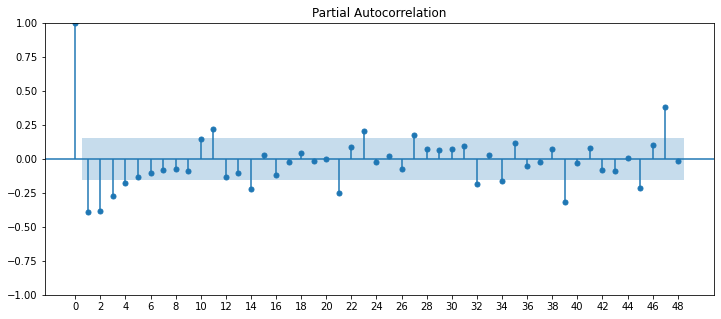

In [8]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(wine['sales_box_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Последний значимый лаг оказался равным 4, значит $p_0=4$. Период сезонности составляет 12. При лаге, равном 12, частичная автокорреляция незначима, значит, $P_0=0$.

Таким образом, будем рассматривать следующие наборы гиперпараметров модели SARIMA:

In [9]:
d=1
D=1
p = range(0, 5)
P = range(0, 2)
q = range(0, 3)
Q = range(0, 2)

In [10]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [11]:
len(parameters_list)

60

## 1.4. Выбор оптимальной модели

Получили 60 возможных наборов гиперпараметров. Гиперпараметры модели нельзя выбирать методом максимального правдоподобия, поскольку с увеличением количества параметров значение функции правдоподобия $L$ растет. 

Поэтому для сравнения различных моделей применяется информационный критерий Акаике:
$$AIC=-2L+2k,$$
где $k$ &ndash; число параметров модели. Чем меньше значение данного критерия, тем лучше.

В цикле будем строить модель SARIMAX `model` и, если полученное значение критерия Акаике `aic` меньше, чем на предыдущих шагах, запишем эту модель в переменную `best_model`. Модель SARIMAX принимает первым аргументом (или через `endog`) исходный ряд. Экзогенные факторы можно передать в виде матрицы в аргументе `exog`. В `seasonal_order` передается набор гиперпараметров `(P,D,Q,S)`, где `S` &ndash; период сезонности. Примерное время выполнения: 3 минуты.

In [12]:
wine.index.freq = 'MS'

In [13]:
results = []
best_aic = float('inf')

for params in parameters_list:
    try:
        model = SARIMAX(wine['sales_box'],
                        order=(params[0], d, params[1]), 
                        seasonal_order=(params[2], D, params[3], 12)).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = params
    results.append([params, model.aic])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22333D+00    |proj g|=  9.78275D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   7.345D-06   3.222D+00
  F =   3.2219271998584769     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18855D+00    |proj g|=  4.46030D-02

At iterate    5    f=  3.12723D+00    |proj g|=  1.31147D-02

At iterate   10    f=  3.12663D+00    |proj g|=  4.62384D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   5.289D-06   3.127D+00
  F =   3.1266259945117807     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     10      1     0     0   4.853D-06   2.893D+00
  F =   2.8934844274473748     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96480D+00    |proj g|=  9.87859D-02

At iterate    5    f=  2.85256D+00    |proj g|=  1.54972D-02

At iterate   10    f=  2.84695D+00    |proj g|=  4.32463D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   1.587D-05   2.847D+00
  F =   2.8469505379476625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28697D+00    |proj g|=  5.80849D-01

At iterate    5    f=  2.96749D+00    |proj g|=  4.60773D-02

At iterate   10    f=  2.95867D+00    |proj g|=  2.09865D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  2.84782D+00    |proj g|=  1.77107D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   9.994D-06   2.848D+00
  F =   2.8478190933309988     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22850D+00    |proj g|=  5.87638D-01

At iterate    5    f=  2.89915D+00    |proj g|=  4.56398D-02

At iterate   10    f=  2.89161D+00    |proj g|=  2.25015D-03

       

/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22629D+00    |proj g|=  5.86341D-01

At iterate    5    f=  2.86372D+00    |proj g|=  7.82321D-02

At iterate   10    f=  2.84420D+00    |proj g|=  1.55982D-03

At iterate   15    f=  2.84418D+00    |proj g|=  5.30918D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     16      1     0     0   5.309D-06   2.844D+00
  F =   2.8441825736682778     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09491D+00    |proj g|=  9.41301D-02

At iterate    5    f=  3.03249D+00    |proj g|=  4.26544D-02

At iterate   10    f=  3.02553D+00    |proj g|=  1.34735D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   5.714D-06   3.026D+00
  F =   3.0255194440538471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.95924D+00    |proj g|=  1.16311D-03

At iterate   10    f=  2.95910D+00    |proj g|=  3.53615D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   1.609D-06   2.959D+00
  F =   2.9591003775751124     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93696D+00    |proj g|=  1.40748D-01

At iterate    5    f=  2.86267D+00    |proj g|=  1.00599D-01


 This problem is unconstrained.



At iterate   10    f=  2.84985D+00    |proj g|=  1.13512D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   9.309D-07   2.850D+00
  F =   2.8498458022295847     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94563D+00    |proj g|=  1.53495D-01

At iterate    5    f=  2.89910D+00    |proj g|=  3.95502D-02

At iterate   10    f=  2.89294D+00    |proj g|=  2.34288D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   9.296D-06   2.892D+00
  F =   2.8923841811417743     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94470D+00    |proj g|=  1.52498D-01

At iterate    5    f=  2.87134D+00    |proj g|=  7.52755D-02


 This problem is unconstrained.



At iterate   10    f=  2.84647D+00    |proj g|=  8.84184D-03

At iterate   15    f=  2.84524D+00    |proj g|=  1.03136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   6.043D-06   2.845D+00
  F =   2.8452411800817345     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95747D+00    |proj g|=  3.98325D-02

At iterate    5    f=  2.95445D+00    |proj g|=  7.18286D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.94627D+00    |proj g|=  4.95334D-03

At iterate   20    f=  2.94478D+00    |proj g|=  9.00436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   7.450D-06   2.945D+00
  F =   2.9447241399798028     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90406D+00    |proj g|=  9.08698D-02

At iterate    5    f=  2.85589D+00    |proj g|=  1.63434D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  2.89258D+00    |proj g|=  6.43821D-03

At iterate   10    f=  2.88369D+00    |proj g|=  3.55349D-02

At iterate   15    f=  2.88234D+00    |proj g|=  1.05386D-03

At iterate   20    f=  2.88224D+00    |proj g|=  5.33098D-05

At iterate   25    f=  2.88224D+00    |proj g|=  3.81216D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     35      1     0     0   9.642D-06   2.882D+00
  F =   2.8822425133380167     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f=  2.84686D+00    |proj g|=  1.76389D-03

At iterate   15    f=  2.84644D+00    |proj g|=  1.18705D-02

At iterate   20    f=  2.84021D+00    |proj g|=  3.17409D-02

At iterate   25    f=  2.83832D+00    |proj g|=  1.67702D-04

At iterate   30    f=  2.83832D+00    |proj g|=  2.92298D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     39      1     0     0   6.212D-07   2.838D+00
  F =   2.8383197773504976     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.93044D+00    |proj g|=  1.86578D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   1.992D-07   2.930D+00
  F =   2.9304351492922023     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00465D+00    |proj g|=  6.05434D-02

At iterate    5    f=  2.99345D+00    |proj g|=  2.35620D-02

At iterate   10    f=  2.99229D+00    |proj g|=  1.55103D-06

       

 This problem is unconstrained.



At iterate    5    f=  2.93475D+00    |proj g|=  2.26247D-02

At iterate   10    f=  2.92890D+00    |proj g|=  7.89043D-03

At iterate   15    f=  2.92879D+00    |proj g|=  4.46265D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   4.463D-07   2.929D+00
  F =   2.9287870630640800     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98420D+00    |proj g|=  1.30384D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.94976D+00    |proj g|=  1.96356D-02

At iterate   10    f=  2.94832D+00    |proj g|=  3.05260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   2.411D-06   2.948D+00
  F =   2.9482889839445581     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92591D+00    |proj g|=  1.61861D-01

At iterate    5    f=  2.84157D+00    |proj g|=  3.15264D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  2.87430D+00    |proj g|=  3.61758D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   4.341D-06   2.874D+00
  F =   2.8743009571029705     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93295D+00    |proj g|=  1.75100D-01


 This problem is unconstrained.



At iterate    5    f=  2.83502D+00    |proj g|=  3.77426D-02

At iterate   10    f=  2.83178D+00    |proj g|=  9.18358D-04

At iterate   15    f=  2.83178D+00    |proj g|=  1.46513D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     19      1     0     0   2.772D-06   2.832D+00
  F =   2.8317794681392132     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95757D+00    |proj g|=  5.35895D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.83629D+00    |proj g|=  2.54425D-02

At iterate   10    f=  2.83349D+00    |proj g|=  8.99904D-04

At iterate   15    f=  2.83320D+00    |proj g|=  9.80454D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   5.155D-06   2.833D+00
  F =   2.8331934709185713     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90347D+00    |proj g|=  8.53795D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  2.87429D+00    |proj g|=  1.98939D-03

At iterate   20    f=  2.87428D+00    |proj g|=  2.60541D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     23      1     0     0   4.072D-06   2.874D+00
  F =   2.8742758653840066     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90266D+00    |proj g|=  9.25180D-02


 This problem is unconstrained.



At iterate    5    f=  2.84307D+00    |proj g|=  1.53516D-01

At iterate   10    f=  2.83133D+00    |proj g|=  1.88965D-03

At iterate   15    f=  2.83132D+00    |proj g|=  2.62044D-04

At iterate   20    f=  2.83130D+00    |proj g|=  6.58182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     26      1     0     0   5.597D-05   2.831D+00
  F =   2.8312950232712977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.90954D+00    |proj g|=  4.60677D-02

At iterate   10    f=  2.90653D+00    |proj g|=  9.60836D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   9.608D-06   2.907D+00
  F =   2.9065340182642179     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96794D+00    |proj g|=  8.04756D-02

At iterate    5    f=  2.95850D+00    |proj g|=  2.50051D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.95739D+00    |proj g|=  3.08313D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   3.083D-06   2.957D+00
  F =   2.9573880805896211     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96695D+00    |proj g|=  8.87656D-02

At iterate    5    f=  2.90854D+00    |proj g|=  6.19183D-02

At iterate   10    f=  2.90215D+00    |proj g|=  6.28781D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.94814D+00    |proj g|=  1.69300D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   2.100D-06   2.948D+00
  F =   2.9481394605744669     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93707D+00    |proj g|=  1.30909D-01

At iterate    5    f=  2.84684D+00    |proj g|=  8.30133D-02

At iterate   10    f=  2.83490D+00    |proj g|=  6.19057D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  2.88575D+00    |proj g|=  6.76634D-02

At iterate   10    f=  2.87433D+00    |proj g|=  2.16476D-03

At iterate   15    f=  2.87429D+00    |proj g|=  1.14513D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     19      1     0     0   1.145D-06   2.874D+00
  F =   2.8742909092830726     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94409D+00    |proj g|=  1.43322D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  2.83170D+00    |proj g|=  1.42838D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.150D-06   2.832D+00
  F =   2.8316977175182294     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.57738D+00    |proj g|=  3.56755D+00

At iterate    5    f=  2.98102D+00    |proj g|=  1.08001D-01

At iterate   10    f=  2.94260D+00    |proj g|=  8.80506D-03


/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   15    f=  2.94046D+00    |proj g|=  2.11039D-03

At iterate   20    f=  2.94031D+00    |proj g|=  2.24540D-04

At iterate   25    f=  2.94029D+00    |proj g|=  1.43631D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     30      1     0     0   3.749D-06   2.940D+00
  F =   2.9402818153675891     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.33606D+00    |proj g|=  3.15077D+00


/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  2.87145D+00    |proj g|=  6.22502D-02

At iterate   10    f=  2.82773D+00    |proj g|=  1.08690D-02

At iterate   15    f=  2.82722D+00    |proj g|=  2.72602D-03

At iterate   20    f=  2.82720D+00    |proj g|=  7.29946D-04

At iterate   25    f=  2.82718D+00    |proj g|=  2.31324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     31      1     0     0   1.236D-05   2.827D+00
  F =   2.8271810389147096     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.40819D+00    |proj g|=  3.28286D+00

At iterate    5    f=  2.90650D+00    |proj g|=  7.22231D-02

At iterate   10    f=  2.86773D+00    |proj g|=  5.07341D-03

At iterate   15    f=  2.86753D+00    |proj g|=  1.20007D-03

At iterate   20    f=  2.86734D+00    |proj g|=  1.73004D-03

At iterate   25    f=  2.86727D+00    |proj g|=  2.20882D-03

At iterate   30    f=  2.86725D+00    |proj g|=  7.40192D-04

At iterate   35    f=  2.86725D+00    |proj g|=  5.11460D-05

At iterate   40    f=  2.86725D+00    |proj g|=  1.66071D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  2.88562D+00    |proj g|=  6.35103D-02

At iterate   10    f=  2.82547D+00    |proj g|=  3.17009D-03

At iterate   15    f=  2.82519D+00    |proj g|=  1.22712D-03

At iterate   20    f=  2.82513D+00    |proj g|=  6.97757D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     26      1     0     0   1.258D-05   2.825D+00
  F =   2.8251341896371724     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.87424D+00    |proj g|=  2.09447D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     15      1     0     0   3.391D-06   2.874D+00
  F =   2.8742398003051908     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94004D+00    |proj g|=  6.47326D-02

At iterate    5    f=  2.92480D+00    |proj g|=  2.53785D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.92322D+00    |proj g|=  5.07301D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     14      1     0     0   2.327D-06   2.923D+00
  F =   2.9232247474410542     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93925D+00    |proj g|=  1.09975D-01

At iterate    5    f=  2.88652D+00    |proj g|=  1.10845D-01

At iterate   10    f=  2.87228D+00    |proj g|=  2.46269D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     21      1     0     0   5.350D-06   2.947D+00
  F =   2.9473985937095546     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91869D+00    |proj g|=  1.40461D-01

At iterate    5    f=  2.84077D+00    |proj g|=  5.81169D-02

At iterate   10    f=  2.83067D+00    |proj g|=  4.87989D-03

At iterate   15    f=  2.83039D+00    |proj g|=  2.52334D-04

       

 This problem is unconstrained.



At iterate   15    f=  2.87256D+00    |proj g|=  1.34274D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     18      1     0     0   1.343D-05   2.873D+00
  F =   2.8725554442835812     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92377D+00    |proj g|=  1.57362D-01

At iterate    5    f=  2.84857D+00    |proj g|=  1.45495D-01


 This problem is unconstrained.



At iterate   10    f=  2.82963D+00    |proj g|=  5.62896D-03

At iterate   15    f=  2.82899D+00    |proj g|=  9.83248D-04

At iterate   20    f=  2.82897D+00    |proj g|=  5.46972D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     23      1     0     0   1.471D-05   2.829D+00
  F =   2.8289707421316042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29836D+00    |proj g|=  6.02961D-01

At iter

/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  2.94805D+00    |proj g|=  2.64662D-04

At iterate   20    f=  2.94795D+00    |proj g|=  7.63821D-03

At iterate   25    f=  2.94775D+00    |proj g|=  5.26622D-03

At iterate   30    f=  2.94751D+00    |proj g|=  4.38381D-03

At iterate   35    f=  2.94713D+00    |proj g|=  8.48261D-03

At iterate   40    f=  2.94689D+00    |proj g|=  8.37323D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     49      1     0     0   9.162D-06   2.947D+00
  F =   2.9468876556532693     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.84509D+00    |proj g|=  3.58444D-02

At iterate   10    f=  2.83062D+00    |proj g|=  6.51814D-03

At iterate   15    f=  2.83055D+00    |proj g|=  3.22955D-04

At iterate   20    f=  2.83052D+00    |proj g|=  2.78736D-03

At iterate   25    f=  2.83050D+00    |proj g|=  6.63754D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     32      1     0     0   8.950D-06   2.830D+00
  F =   2.8304987306830416     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23754D+00    |proj g|=  6.10009D-01

At iterate    5    f=  2.88347D+00    |proj g|=  3.08118D-02

At iterate   10    f=  2.87239D+00    |proj g|=  1.89233D-03

At iterate   15    f=  2.87236D+00    |proj g|=  1.94909D-03

At iterate   20    f=  2.87229D+00    |proj g|=  1.96190D-03

At iterate   25    f=  2.87228D+00    |proj g|=  1.17603D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     28      1     0     0   

/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.85573D+00    |proj g|=  5.50509D-02

At iterate   10    f=  2.82895D+00    |proj g|=  1.34366D-03

At iterate   15    f=  2.82892D+00    |proj g|=  5.55746D-04

At iterate   20    f=  2.82883D+00    |proj g|=  3.09969D-03

At iterate   25    f=  2.82874D+00    |proj g|=  4.12596D-04

At iterate   30    f=  2.82738D+00    |proj g|=  3.72788D-02

At iterate   35    f=  2.82524D+00    |proj g|=  6.95324D-03

At iterate   40    f=  2.82462D+00    |proj g|=  1.87016D-03

At iterate   45    f=  2.82461D+00    |proj g|=  7.44459D-04

At iterate   50    f=  2.82460D+00    |proj g|=  6.68595D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/egor/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

      parameters          aic
21  (1, 2, 0, 1)  1006.024314
29  (2, 1, 0, 1)  1007.801388
31  (2, 1, 1, 1)  1008.786373
45  (3, 2, 0, 1)  1009.167726
33  (2, 2, 0, 1)  1009.284102


## 1.5. Визуализация результата

Визуализируем лучшую полученную модель. Не забудем выполнить обратное преобразование Бокса-Кокса. Обратное дифференцирование будет выполнено функцией SARIMAX.

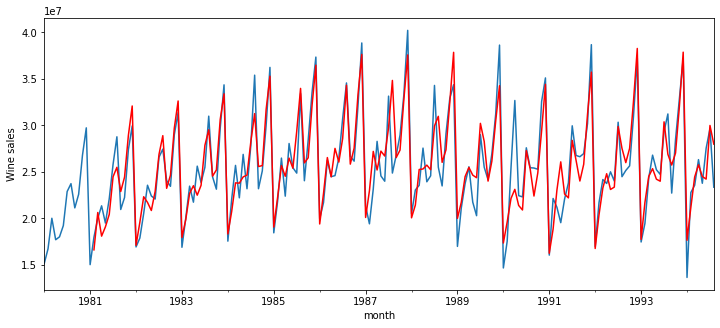

In [16]:
wine['model'] = inv_boxcox(best_model.fittedvalues, lmbda)
wine['sales'].plot(figsize=(12,5))
wine.model[13:].plot(color='r')
plt.ylabel('Wine sales')
plt.show()

Прогноз можно получить с помощью методов `predict` (предпочтителен) или `forecast`. `predict` принимает на вход параметры `start` и `end`, в которые необходимо передать даты начала и конца прогноза. `forecast` же принимает на вход целое число &ndash; горизонт прогнозирования (опирается на индексы таблицы и может неверно их интерпретировать).

In [17]:
start = wine.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)

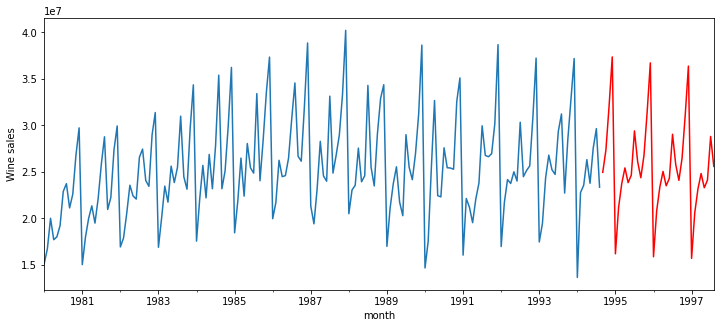

In [18]:
wine['sales'].plot(figsize=(12,5))
inv_boxcox(best_model.predict(start=start, end=end), lmbda).plot(color='r')
plt.ylabel('Wine sales')
plt.show()

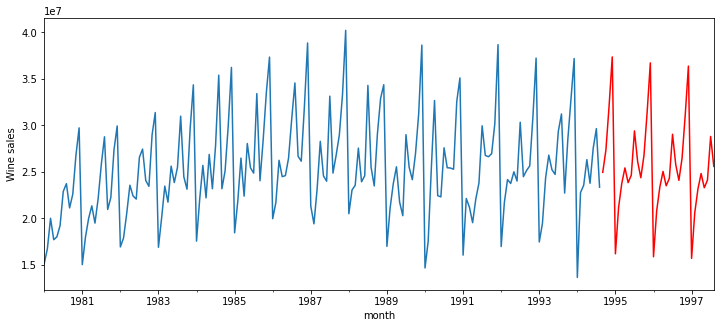

In [19]:
wine['sales'].plot(figsize=(12,5))
inv_boxcox(best_model.forecast(36), lmbda).plot(color='r')
plt.ylabel('Wine sales')
plt.show()

# 2. Введение в модель Prophet

Для дальнейшей работы понадобится установленная библиотека **FBProphet**: https://facebook.github.io/prophet/.

Для установки откройте терминал анаконды (Anaconda Promt) и запустите следующую команду: `conda install -c conda-forge fbprophet`.

Prophet для визуализации результатов прогнозирования обращается к библиотеке **Plotly**: https://plotly.com/python/, которая позволяет строить интерактивные графики. Можно также установить через conda: `conda install -c plotly plotly=4.6.0` или же через pip. Установка данной библиотеки необязательна.

Подробное описание методов построения прогноза можно найти в работе Forecasting at scale (Facebook Prophet documentation preprint).

Модель прогнозирования в библиотеке от Facebook имеет название `Prophet`. Основной идеей построения прогноза стало разложение временного ряда на основные составляющие:

$$y(t)=g(t)+s(t)+h(t)+f(t)+\epsilon_t,$$

где $g(t)$ &ndash; функция, описывающая тренд временного ряда, $s(t)$ &ndash; компонента, описывающая сезонные колебания, $h(t)$ &ndash; компонента, отвечающая за различные праздники и события, которые могут оказывать влияние на целевую переменную $y(t)$, $f(t)$ &ndash; компонента, учитывающая экзогенные факторы, а $\epsilon_t$ представляет собой непрогнозируемую перечисленными компонентами ошибку.

Построим модель прогнозирования для ряда продаж вина.

## 2.1. Инициализация и обучение модели

In [20]:
from fbprophet import Prophet

Функция `Prophet` требует, чтобы исходная таблица с данными содержала два столбца: `ds` с моментами времени и `y` с соответствующими значениями целевой переменной. В предыдущей работе при загрузке набора данных `wine` даты использовались в качестве индексов наблюдений. Поскольку теперь для корректной работы функции данные обязательно должны содержать указанные два столбца, используется индекс по умолчанию. Названия столбцов изменим на `ds` и `y`. Будем использовать ряд после преобразования Бокса-Кокса.

In [21]:
wine.head()

,sales,sales_box,sales_box_sdiff,sales_box_diff,model
month,,,,,
1980-01-01,15136000,207.210491,NaN,NaN,1.000000e+00
1980-02-01,16733000,212.290060,NaN,NaN,1.513478e+07
1980-03-01,20016000,221.667748,NaN,NaN,1.673294e+07
1980-04-01,17708000,215.211724,NaN,NaN,2.001587e+07
1980-05-01,18019000,216.117795,NaN,NaN,1.770809e+07


In [22]:
wine_prophet = wine[['sales_box']]
wine_prophet = wine_prophet.reset_index()
wine_prophet.columns = ['ds', 'y']

In [23]:
wine_prophet.head()

,ds,y
0,1980-01-01,207.210491
1,1980-02-01,212.290060
2,1980-03-01,221.667748
3,1980-04-01,215.211724
4,1980-05-01,216.117795


Последовательность построения модели схожа с построением `SARIMAX` из statsmodels с единственным отличием: структура модели задается без указания прогнозируемого ряда. Обучение происходит с помощью той же функциии `fit`, где уже указывается набор данных в виде `pd.DataFrame` с указанными выше столбцами.

In [24]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.fit(wine_prophet)

Initial log joint probability = -2.50026


/home/egor/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       626.065   0.000882265       159.006           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       626.294   0.000762811       76.0905           1           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202         626.3   6.38128e-05       54.6773   9.573e-07       0.001      326  LS failed, Hessian reset 
     251       626.322   0.000119154       77.1791    1.48e-06       0.001      441  LS failed, Hessian reset 
     265       626.326     7.753e-07       42.7189   1.781e-08       0.001      498  LS failed, Hessian reset 
     299       626.327   1.21808e-06       46.4555       0.563       0.563      554   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       626.328   1.49029e-05  

Для построения прогноза потребуется также передать `pd.DataFrame`, содержащий столбец `ds`. Для создания такой таблицы в Prophet предусмотрена функция `make_future_dataframe`, в которой можно указать горизонт прогнозирования `periods` и частоту наблюдений `freq`. Без указанной частоты будет построен подневный прогноз. Будем также строить прогноз на 3 года вперед. `make_future_dataframe` вернет даты с первого наблюдения до последней даты прогноза.

In [25]:
future = model.make_future_dataframe(periods=36, freq='MS')

Аппроксимацию построенной моделью и прогноз теперь можно получить с помощью функции `predict`, которая вернет `pd.DataFrame` с результатами.

In [26]:
forecast = model.predict(future)

/home/egor/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/egor/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Приведем оценки модели и прогнозный интервал для последних 12 спрогнозированных значений:

In [27]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
200,1996-09-01,232.121051,226.204101,238.223301
201,1996-10-01,239.041773,233.554866,244.595825
202,1996-11-01,248.905788,243.436180,254.457497
203,1996-12-01,256.132914,250.336812,261.769164
204,1997-01-01,214.910150,209.028555,220.934795
205,1997-02-01,224.118325,218.436662,229.977170
206,1997-03-01,233.275034,227.562819,239.220798
207,1997-04-01,234.147325,228.205513,240.142718
208,1997-05-01,232.998093,227.169186,238.400972
209,1997-06-01,232.666853,226.683753,238.678258


Для удобства `Prophet` позволяет сразу отобразить результаты на графике.

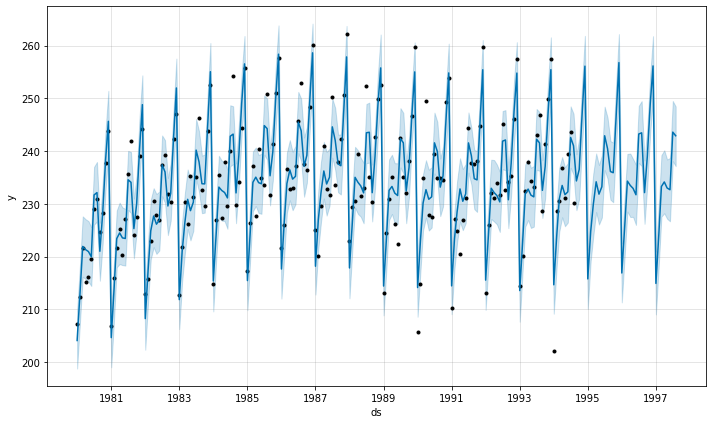

In [28]:
model.plot(forecast)
plt.show()

## 2.2. Моделирование тренда

Prophet позволяет моделировать затухающий тренд, задав при этом порог насыщения. Такая возможность может пригодиться, например, при прогнозировании числа пассажиров на рейс, где ограничена вместимость воздушного судна, которое назначено на данный рейс. В данном случае порог можно установить равным вместимости судна. Для моделирования затухающего тренда при инициализации модели необходимо указать `growth = 'logistic'`. Установить порог можно, добавив к данным столбец `cap` для ограничения сверху или `floor` для ограничения снизу.

In [29]:
# model_logistic = Prophet(growth='logistic')

Кроме того, в Prophet реализована возможность задавать точки изменения тренда (changepoints). По умолчанию Prophet равномерно распределяет 25 таких точек по ряду.

In [30]:
# model_changepoints = Prophet(changepoints=['2014-01-01'])

## 2.3. Моделирование сезонности

Для моделирования сезонности в пакете Prophet используется ничто иное как Фурье-преобразования, которые проводятся по формулам:

$$s(t)=\sum_{n=1}^{N}\left(a_n cos \left( \frac{2\pi n t}{P} \right)+b_n sin \left(\frac{2\pi n t}{P}\right) \right).$$

Здесь $N$ &ndash; порядок Фурье-преобразования. Для годовой сезонности эмпирическим путем исследователи Facebook определили оптимальный порядок $N=10$, для недельной сезонности &ndash; $N=3$.

Сезонные составляющие можно передать в модель при инициализации, а можно добавлять сезонные компоненты к уже определенной модели с указанием периода и порядка преобразования.

In [31]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)

Таким образом `add_seasonality` позволяет добавить специфические периоды сезонности, характерные для конкретного ряда, например, с периодом сезонности равном 5, если данные собираются исключительно во время рабочей недели.

При наличии мультипликативной сезонности при инициализации модели указывается опция `seasonality_mode='multiplicative'`.

## 2.4. Добавление праздников

Во временной ряд о продажах вина трудно добавить информацию о праздниках, но по графику заметно, что продажи растут в конце года и падают в начале. Таким образом, можно добавить Новый год в качестве фактора. Список праздников должен быть передан также в виде `pd.DataFrame` с указанием названий праздников в столбце `holiday`, дат праздников `ds`, а также количества дней до `lower_window` и после праздников `upper_window`, в которые также могут наблюдаться изменения спроса.

In [32]:
new_year = pd.DataFrame({'holiday': 'NewYear', 
                         'ds': pd.to_datetime([str(x)+'-01-01' for x in range(1980, 1997)]),
                         'lower_window': -7, 
                         'upper_window': 7
                        })

Список праздников затем передается в модель:

In [33]:
model_holiday = Prophet(weekly_seasonality=False, daily_seasonality=False, holidays=new_year)

Официальные праздники разных стран доступны по их двухбуквенному коду в самом пакете.

In [34]:
model_holidays = Prophet(weekly_seasonality=False, daily_seasonality=False)
model_holidays.add_country_holidays(country_name='AU')
model_holidays.fit(wine_prophet)

Initial log joint probability = -2.50026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/egor/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      78       631.214   6.50051e-05       79.4389   7.546e-07       0.001      136  LS failed, Hessian reset 
      99       631.313   0.000298112       51.1399           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       631.352   7.25146e-05       76.8387   1.064e-06       0.001      211  LS failed, Hessian reset 
     148       631.457    0.00011739        133.11   1.165e-06       0.001      299  LS failed, Hessian reset 
     199       631.514   2.15267e-05       40.0562      0.5555      0.5555      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       631.514    3.2645e-06       55.1825   6.435e-08       0.001      410  LS failed, Hessian reset 
     256       631.534   5.36587e-06       47.8975   1.185e-07       0.001      540  LS failed, Hessian reset 
     288       631.546   1.80654e-05       61.0966   2.895e-07       0.001      621  LS

In [35]:
model_holidays.train_holiday_names

0                New Year's Day
1     New Year's Day (Observed)
2                 Australia Day
3                   Good Friday
4                 Easter Monday
5                     Anzac Day
6                 Christmas Day
7                    Boxing Day
8      Australia Day (Observed)
9         Boxing Day (Observed)
10     Christmas Day (Observed)
dtype: object

## 2.5. Добавление экзогенных факторов

Дополнительные факторы, которые могут улучшить качество прогноза можно добавить с помощью функции `add_regressor`. Исключительно для примера обратим внимание модели на декабрь каждого года.

In [36]:
def december(ds):
    return 1 if ds.month == 12 else 0

Чтобы добавить дополнительные переменные в модель, их необходимо добавить к матрице с данными `wine_prophet` и затем указать в модели названия колонок с дополнительными переменными.

In [37]:
wine_prophet['december'] = wine_prophet['ds'].apply(december)
wine_prophet.head()

,ds,y,december
0,1980-01-01,207.210491,0
1,1980-02-01,212.290060,0
2,1980-03-01,221.667748,0
3,1980-04-01,215.211724,0
4,1980-05-01,216.117795,0


In [38]:
model_december = Prophet(weekly_seasonality=False, daily_seasonality=False)
model_december.add_regressor('december')
model_december.fit(wine_prophet)

Initial log joint probability = -2.50026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/egor/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       626.204   0.000342124       45.5771           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       626.251    0.00010164       107.252   8.977e-07       0.001      224  LS failed, Hessian reset 
     161       626.265   1.92322e-05       33.0034   3.004e-07       0.001      302  LS failed, Hessian reset 
     199       626.266   5.68947e-06       46.0816           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       626.302   0.000107043       115.306   1.303e-06       0.001      413  LS failed, Hessian reset 
     249       626.316   4.26432e-05       79.7287   8.781e-07       0.001      522  LS failed, Hessian reset 
     275       626.319   8.61793e-09       32.0181     0.03886      0.1658      571   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Для построения прогноза также необходимо добавить экзогенные факторы:

In [39]:
future_december = model_december.make_future_dataframe(periods=36, freq='MS')
future_december['december'] = future_december['ds'].apply(december)
forecast_december = model_december.predict(future_december)

/home/egor/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/egor/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


<div class="alert alert-info">

<h4> Задание (выполнять в отдельном файле)</h4>
<p></p>
Для своего ряда построить прогноз на несколько периодов сезонности с применением возможностей библиотеки Prophet. Меняя параметры модели, добиться наилучшего качества аппроксимации. Сравнить на графике прогноз модели SARIMAX (задание от 28.03.22) с прогнозом модели Prophet. Сравнить качество аппроксимации моделей с помощью MSE.
</div>

<p></p>
</div>